#### Convolutional Neural Network

In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [86]:
from imutils import paths
import matplotlib.pyplot as plt
import argparse
import os
os.chdir('D:\Datasets\Fire uk')
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

In [3]:
tf.__version__

'2.2.0'

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10141158834007306950
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10305372544935330355
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2147483648
locality {
  bus_id: 1
  links {
  }
}
incarnation: 451770835080939375
physical_device_desc: "device: 0, name: GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 7155725287698173348
physical_device_desc: "device: XLA_GPU device"
]


In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [7]:
# rescale and resize - very imp preprocessing step

In [89]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    r'Dataset\Training',
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
   r'Dataset\Training', # same directory as training data
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation') # set as validation data



# Preprocessing the Test set
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator  = test_datagen.flow_from_directory('Dataset\Test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')


Found 31501 images belonging to 2 classes.
Found 7874 images belonging to 2 classes.
Found 8615 images belonging to 2 classes.


In [9]:
bModel = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224,3 )))  #base_Model
hModel = bModel.output #head_Model
hModel = AveragePooling2D(pool_size=(4, 4))(hModel)
hModel = Flatten(name="flatten")(hModel)
hModel = Dense(64, activation="relu")(hModel)
hModel = Dropout(0.5)(hModel)
hModel = Dense(2, activation="softmax")(hModel)
model = Model(inputs=bModel.input, outputs=hModel)
for layer in bModel.layers:
    layer.trainable = False

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

checkpoint = ModelCheckpoint(r"models\model2.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

In [11]:
# Part 3 - Training the CNN

# Compiling the CNN
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the CNN on the Training set and evaluating it on the Test set
history=model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // 32,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // 32,
    callbacks=callbacks,
    epochs = 10)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
984/984 [==============================] - ETA: 0s - loss: 0.1744 - accuracy: 0.9410
Epoch 00001: val_loss improved from inf to 0.11601, saving model to D:\Datasets\Fire uk\models\model2.h5
984/984 [==============================] - 1201s 1s/step - loss: 0.1744 - accuracy: 0.9410 - val_loss: 0.1160 - val_accuracy: 0.9567
Epoch 2/10
984/984 [==============================] - ETA: 0s - loss: 0.1213 - accuracy: 0.9576
Epoch 00002: val_loss improved from 0.11601 to 0.10532, saving model to D:\Datasets\Fire uk\models\model2.h5
984/984 [==============================] - 1015s 1s/step - loss: 0.1213 - accuracy: 0.9576 - val_loss: 0.1053 - val_accuracy: 0.9538
Epoch 3/10
984/984 [==============================] - ETA: 0s - loss: 0.1084 - accuracy: 0.9605
Epoch 00003: val_loss improved from 0.10532 to 0.10157, saving model to D:\Datasets\Fire uk\models\model2.h5
984/984 [==============================] - 1118

In [17]:
loss_tr, acc_tr = model.evaluate_generator(train_generator)

In [18]:
print(loss_tr)
print(acc_tr)

0.09077030420303345
0.9644138216972351


In [19]:
loss_vr, acc_vr = model.evaluate_generator(validation_generator)

In [20]:
print(loss_vr)
print(acc_vr)

0.10499019175767899
0.9563119411468506


In [21]:
loss_test, acc_test= model.evaluate_generator(test_generator)

In [22]:
print(loss_test)
print(acc_test)

0.8788148760795593
0.7560069561004639


In [93]:
import pandas as pd
loss=[loss_tr,loss_vr,loss_test]
accuracy=[acc_tr * 100,acc_vr * 100,acc_test * 100]
df=pd.DataFrame(loss,columns=['loss'],index=['Training','Validation','Test'])
df['Accuracy']=accuracy
import dataframe_image as dfi
dfi.export(df, r'Outputs\results.png')
df

,loss,Accuracy
Training,0.090770,96.441382
Validation,0.104990,95.631194
Test,0.878815,75.600696


In [ ]:
# save it as a h5 file


#cnn.save(r'D:\Datasets\Fire uk\models\model.h5')

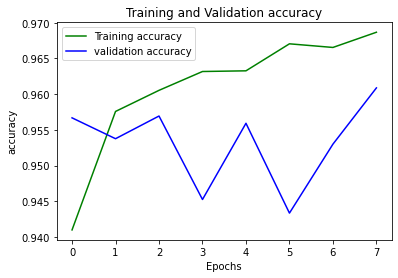

In [90]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(0,8)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('Outputs\Training_vs_Validation_accuracy.png')
plt.show()

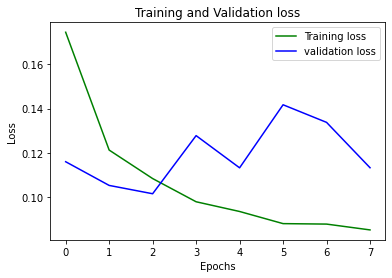

In [91]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(0,8)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Outputs\Training_vs_Validation_loss.png')
plt.show()

# Testing on Single Image

In [94]:
from tensorflow.keras.models import load_model
 
# load model
model = load_model(r'models\model2.h5')

In [95]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [43]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import PIL

In [49]:
image_for_testing=r'Dataset\Training\Fire\resized_frame0.jpg'

[[0.97771156 0.02228842]]


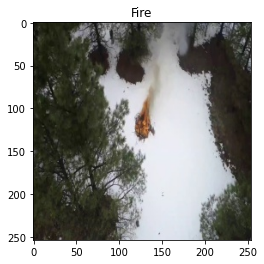

In [50]:
test_image=image.load_img(image_for_testing,target_size=(224,224))
test_image=image.img_to_array(test_image)
test_image=test_image/255
test_image=np.expand_dims(test_image,axis=0)
result=model.predict(test_image)

image_show=PIL.Image.open(image_for_testing)
plt.imshow(image_show)
print(result)
if np.argmax(result)==0:
    plt.title("Fire")
else:
    plt.title("No Fire")

plt.show()

# Testing on Multiple images

In [ ]:
from IPython.display import display

In [87]:
list_result=[]
def process_images():
    for i in os.listdir(r'mixed'):
        images=r'mixed/'+i
        print(images)
        #display(images)

        test_image=image.load_img(images,target_size=(254,254))
        test_image=image.img_to_array(test_image)
        test_image=test_image/255
        test_image=np.expand_dims(test_image,axis=0)
        result=model.predict(test_image)
        list_result.append(result)
        image_show=PIL.Image.open(images)
        plt.imshow(image_show)
        if np.argmax(result)==0:
            plt.title("Fire")
        else:
            plt.title("No Fire")

        plt.show()

mixed/resized_frame0.jpg


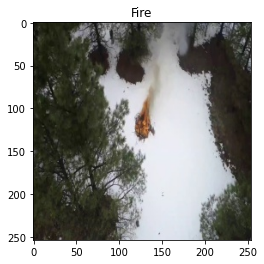

mixed/resized_frame1.jpg


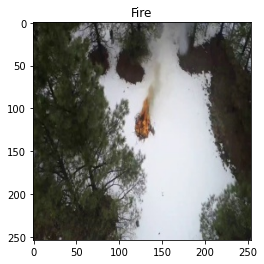

mixed/resized_frame3.jpg


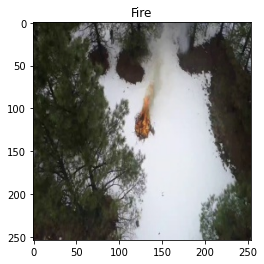

mixed/resized_test_nofire_frame0.jpg


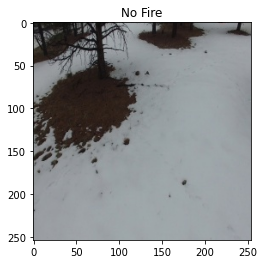

mixed/resized_test_nofire_frame3.jpg


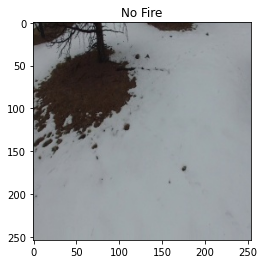

mixed/resized_test_nofire_frame5.jpg


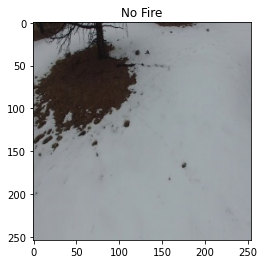

In [88]:
process_images()